<a href="https://colab.research.google.com/github/nahumsa/Variational-Autoencoder/blob/Entanglement/VAE%20Entanglement%20Witness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating entangled and separable states with qutip

## Installing dependencies

In [24]:
!git clone https://github.com/nahumsa/VAE-RBM-Pretraining

Cloning into 'VAE-RBM-Pretraining'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 58 (delta 23), reused 33 (delta 11), pack-reused 0
Unpacking objects: 100% (58/58), done.


In [2]:
!pip install qutip

     |████████████████████████████████| 3.5MB 2.9MB/s 
  Created wheel for qutip: filename=qutip-4.5.0-cp36-cp36m-linux_x86_64.whl size=12882860 sha256=fb00ec045bbe3c03b7c7b44831a7da1ca044456c1f9539cda995f78b5135aa18
  Stored in directory: /root/.cache/pip/wheels/c9/85/e8/3fbad9a0816141b4c5f1d73d8a880ed91265fea84192cbe37b
Successfully built qutip


In [41]:
% cd VAE-RBM-Pretraining/

/content/VAE-RBM-Pretraining


## Creating the dataset

We want to take the partial transpose of the density matrix and check if it $\rho > 0$. [link](https://en.wikipedia.org/wiki/Peres%E2%80%93Horodecki_criterion)

Here we are following the Perez-Horondecki criterion, if the partial transpose of the density matrix is negative, the state has to be entangled. 

Because it the state is separable, it will be positive definite by definition.

In [3]:
try:
  %tensorflow_version 1.x

except Exception:
  pass
  
import tensorflow as tf
#Set Random Seed for reproduction
tf.compat.v1.set_random_seed(1234)

TensorFlow 1.x selected.


In [0]:
from itertools import product
import qutip as qutip
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

def measurement(density_matrix, base, name_base):
  """Measuring the quantum state on a given basis.
  """
  _measurements_names = []
  _measurements = []

  for (name_1, meas_1),(name_2,meas_2) in product(zip(name_base, base),zip(name_base, base)):
    #Ignore the II measurement because it is always 1
    if name_1 == 'I' and name_2 == 'I':
      pass
    else:
      measurement_op = qutip.tensor(meas_1,meas_2)
      _measurements.append(qutip.expect(measurement_op, density_matrix))
      _measurements_names.append(name_1 + name_2)

  return [i for i in zip(_measurements, _measurements_names)]

def create_density_matrix(base,name_base):
  """ Create a random density matrix."""

  for (name_1, basis_1),(name_2, basis_2) in product(zip(name_base, base),zip(name_base, base)):
    if name_1 == 'I' and name_2 == 'I':
      density_matrix = 0.25*qutip.tensor(basis_1, basis_2)
    else: 
      density_matrix += 0.25*np.random.rand()*qutip.tensor(basis_1,basis_2)
  
  return density_matrix

def create_dataset(n_samples):
  
  _states = []
  _labels = []
  _measurements = []

  #Basis Measured
  name_basis = ['I', 'X', 'Y', 'Z']
  basis = [qutip.identity(2), qutip.sigmax(),qutip.sigmay(),qutip.sigmaz()]



  for _ in range(n_samples):    
    density = qutip.rand_dm(4, density=0.75, dims=[[2,2],[2,2]])
    
    #Partial Transpose
    density_partial_T = qutip.partial_transpose(density, [0,1])    
  
    #Labels: 1 if entangled -1 if separable (PPT Criterion)
    if (density_partial_T.eigenenergies() < 0).any():
      _labels.append(1)
  
    else:
      _labels.append(-1)  

    _states.append(density)  
  
    val_measurements = measurement(density_matrix=density, 
                                   base=basis, 
                                   name_base=name_basis)
  
    _measurements.append(val_measurements)
    
  return _states, _measurements, _labels

In [0]:
samples_train = 5000
states_train, measurements_train, labels_train = create_dataset(samples)

samples_test = 500
states_test, measurements_test, labels_test = create_dataset(samples)

Checking the distribution of the labels.

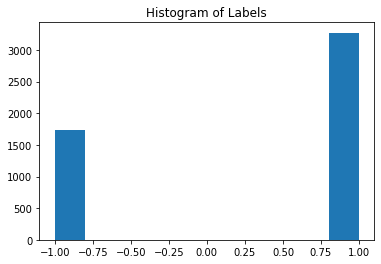

In [118]:
plt.hist(labels_train)
plt.title('Histogram of Labels')
plt.show()

In [0]:
#Unpacking the training data
def create_x(measurement):
  """Create an list with measurements"""
  X = []
  for meas in measurement:
    aux = []
    for result ,_ in meas:
      aux.append(result)
    X.append(aux)
  return X

#Transforming in an np.array
X_train = np.array(create_x(measurements_train))
Y_train = np.array(labels_train)

X_test = np.array(create_x(measurements_test))
Y_test = np.array(labels_test)

In [120]:
print(f"Shape of the Training: \n X: {X_train.shape} \n Y:{Y_train.shape}")

Shape of the Training: 
 X: (5000, 15) 
 Y:(5000,)


Making the binary training data for the RBM. We select a threshold to transform into binary.

In [0]:
threshold = 0
X_train_bw = (X_train > threshold).astype(int)

In [122]:
X_train_bw.shape

(5000, 15)

# Build a Variational Autoencoder

In [0]:
import os
# run params
SECTION = 'bvae_RBM'
RUN_ID = '0001'
DATA_NAME = 'Entanglement'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

In [124]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
from keras.models import Model
from Models.VAE import VariationalAutoencoder

#Parameters
layers = [15, 256, 512, 2]
epochs_pretraining = 1

#Defining the Beta-VAE
bvae = VariationalAutoencoder(layer_dims = layers)
bvae.pretrain(X_train_bw,epochs = epochs_pretraining, num_samples = 1000)
bvae.unroll()

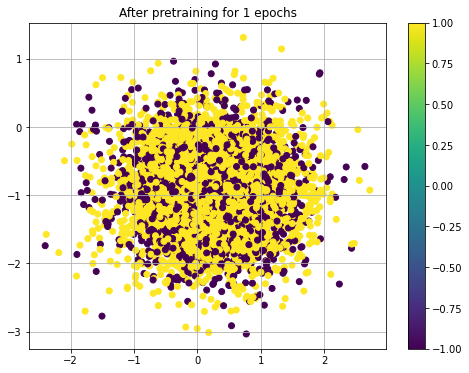

In [128]:
z_mu = bvae.encoder.predict(X_test)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=Y_test)
plt.colorbar()
plt.title(f'After pretraining for {epochs_pretraining} epochs')
plt.grid()

In [129]:
bvae.model.summary()

Model: "model_38"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 15)           0                                            
__________________________________________________________________________________________________
encoder_dense_0 (Dense)         (None, 256)          4096        encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_dense_1 (Dense)         (None, 512)          131584      encoder_dense_0[0][0]            
__________________________________________________________________________________________________
mu (Dense)                      (None, 2)            1026        encoder_dense_1[0][0]            
___________________________________________________________________________________________

In [0]:
#Compile Parameters (These parameters depend on a fine tuning) 
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 5000
BETA = 10
bvae.compile(LEARNING_RATE, R_LOSS_FACTOR, BETA)

In [0]:
# Training Parameters

BATCH_SIZE = 126

EPOCHS = 100

PRINT_EVERY_N_BATCHES = 100

INITIAL_EPOCH = 0

In [132]:
bvae.train(     
    x_train = X_train    
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , initial_epoch = INITIAL_EPOCH
          )

Epoch 1/100
5000/5000 [==============================] - 3s 511us/step - loss: 499.4547 - vae_r_loss: 455.2796 - vae_kl_loss: 4.4175
Epoch 2/100
5000/5000 [==============================] - 0s 97us/step - loss: 303.3352 - vae_r_loss: 288.2645 - vae_kl_loss: 1.5071
Epoch 3/100
5000/5000 [==============================] - 0s 98us/step - loss: 290.7639 - vae_r_loss: 281.3504 - vae_kl_loss: 0.9413
Epoch 4/100
5000/5000 [==============================] - 0s 93us/step - loss: 284.4465 - vae_r_loss: 277.1981 - vae_kl_loss: 0.7248
Epoch 5/100
5000/5000 [==============================] - 0s 94us/step - loss: 280.9482 - vae_r_loss: 274.6099 - vae_kl_loss: 0.6338
Epoch 6/100
5000/5000 [==============================] - 0s 96us/step - loss: 278.8918 - vae_r_loss: 273.3383 - vae_kl_loss: 0.5554
Epoch 7/100
5000/5000 [==============================] - 1s 104us/step - loss: 277.3548 - vae_r_loss: 272.3146 - vae_kl_loss: 0.5040
Epoch 8/100
5000/5000 [==============================] - 0s 98us/step - lo

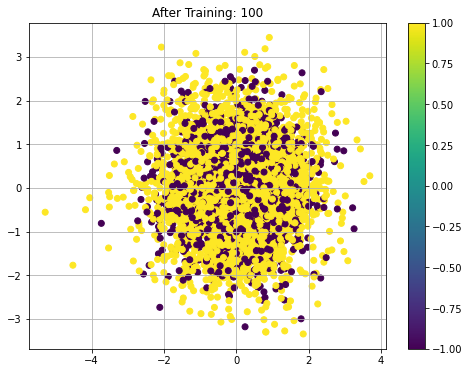

In [133]:
z_mu = bvae.encoder.predict(X_test)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=Y_test)
plt.colorbar()
plt.title(f'After Training: {EPOCHS}')
plt.grid()

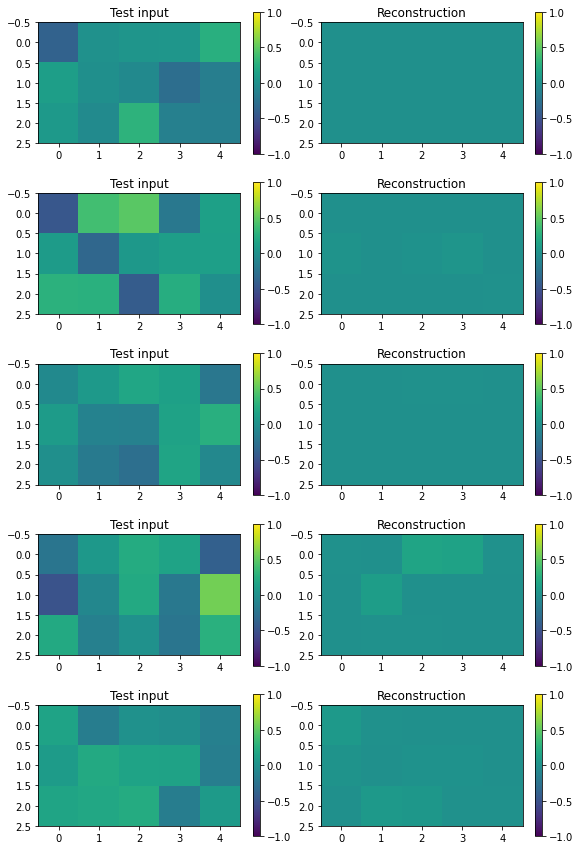

In [139]:
n_to_show = 5
example_idx = np.random.choice(range(len(X_test)), n_to_show)
example_images = X_test[example_idx]

z_points = bvae.encoder.predict(example_images)

reconst_images = bvae.decoder.predict(z_points)

plt.figure(figsize=(8, 12))
for i in range(n_to_show):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(example_images[i].reshape(3,5), vmin=-1, vmax=1)#, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(reconst_images[i].reshape(3,5), vmin=-1, vmax=1)#, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
    
plt.tight_layout()

In [103]:
bvae.model.evaluate(X_test,Y_test)

5000/5000 [==============================] - 0s 81us/step


[4624.0, 4624.0, 1.994037628173828e-06]

In [104]:
bvae.model.predict(X_test)

array([[0.49999952, 0.50000054],
       [0.49999982, 0.50000024],
       [0.4999997 , 0.5000003 ],
       ...,
       [0.49999973, 0.5000003 ],
       [0.4999997 , 0.50000036],
       [0.49999982, 0.5000002 ]], dtype=float32)

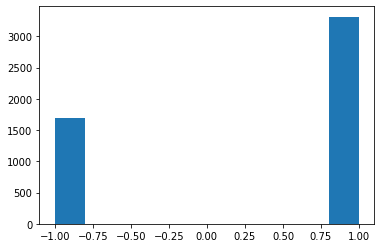

In [98]:
plt.hist(Y_test);